### Next Steps: Choosing the Optimal Number of Features and Performing Bayesian Hyperparameter Optimization for the Best Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import pickle
import warnings
import logging
# from contextlib import redirect_stdout
# import io

# from catboost import CatBoostRegressor
from pytorch_tabnet.tab_model import TabNetRegressor
# import shap

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from kneed import KneeLocator

import torch
import optuna 
from optuna.samplers import TPESampler

In [2]:
########### RUN ME ###########

# master data here
df_2017 = pd.read_csv("../finished_csvs/master_2017.csv")
df_2018 = pd.read_csv("../finished_csvs/master_2018.csv")
df_2019 = pd.read_csv("../finished_csvs/master_2019.csv")
df_2020 = pd.read_csv("../finished_csvs/master_2020.csv")
df_2021 = pd.read_csv("../finished_csvs/master_2021.csv")
df_2022 = pd.read_csv("../finished_csvs/master_2022.csv")
df_2023 = pd.read_csv("../finished_csvs/master_2023.csv")
df_2024 = pd.read_csv("../finished_csvs/master_2024.csv")

dfs = [df_2017, df_2018, df_2019, df_2020,
       df_2021, df_2022, df_2023, df_2024]

print(df_2017.columns)
print(f"This shape should be uniform across all dfs: {df_2017.shape}")

# these will be the same predictor variables for all 8 csv files (2017-2024)
# df_2017.columns[2:66]
predictors = ['A00', 'A01', 'A02', 'A03', 'A04', 'A05', 'A06',
       'A07', 'A08', 'A09', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16',
       'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26',
       'A27', 'A28', 'A29', 'A30', 'A31', 'A32', 'A33', 'A34', 'A35', 'A36',
       'A37', 'A38', 'A39', 'A40', 'A41', 'A42', 'A43', 'A44', 'A45', 'A46',
       'A47', 'A48', 'A49', 'A50', 'A51', 'A52', 'A53', 'A54', 'A55', 'A56',
       'A57', 'A58', 'A59', 'A60', 'A61', 'A62', 'A63']
# likewise, this will be the same target variable ('Cases_20XX_normalized')
# always at the end of the dfs
example_Y = df_2017.columns[-1]

print(predictors)
print('\n')
print(example_Y)

Index(['County', 'GEOID', 'A00', 'A01', 'A02', 'A03', 'A04', 'A05', 'A06',
       'A07', 'A08', 'A09', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16',
       'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26',
       'A27', 'A28', 'A29', 'A30', 'A31', 'A32', 'A33', 'A34', 'A35', 'A36',
       'A37', 'A38', 'A39', 'A40', 'A41', 'A42', 'A43', 'A44', 'A45', 'A46',
       'A47', 'A48', 'A49', 'A50', 'A51', 'A52', 'A53', 'A54', 'A55', 'A56',
       'A57', 'A58', 'A59', 'A60', 'A61', 'A62', 'A63', 'Cases_2017',
       '2017_population', 'Cases_2017_normalized'],
      dtype='object')
This shape should be uniform across all dfs: (102, 69)
['A00', 'A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07', 'A08', 'A09', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27', 'A28', 'A29', 'A30', 'A31', 'A32', 'A33', 'A34', 'A35', 'A36', 'A37', 'A38', 'A39', 'A40', 'A41', 'A42', 'A43', 'A44', 'A45', 'A46', 'A47', 'A48

#### Optimal Threshold for Feature Selection

Using the results from the feature selection, I will use the Feature and Overall columns to select the top k parameters. To determine which are the top k parameters I will use the elbow method.

In [ ]:
df_save = pd.read_csv("embeddings_importance_2017_to_2024.csv").reset_index(drop=True)
df_elbow = df_save[["Feature","Overall"]]
df_elbow

,Feature,Overall
0,A00,0.134834
1,A01,0.138127
2,A02,0.792211
3,A03,0.746003
4,A04,0.442709
...,...,...
59,A59,0.156993
60,A60,0.411560
61,A61,0.144149
62,A62,0.144170


In [ ]:
# in this case, i have my index as my feature name since A00 is the very first feature.
sorted_features = df_elbow["Overall"].sort_values(ascending=False)
x = range(1, len(sorted_features)+1)
kneedle = KneeLocator(x, sorted_features, curve='convex', direction='decreasing')
k = kneedle.knee
print(f"k = {k}")

df_sorted = df_elbow.sort_values("Overall", ascending=False)
top_features = df_sorted["Feature"].iloc[:k].tolist()
print(top_features)
df_elbow.sort_values(by="Overall",ascending=False).nlargest(columns="Overall",n=13)

k = 13
['A21', 'A02', 'A03', 'A40', 'A25', 'A57', 'A42', 'A18', 'A08', 'A33', 'A31', 'A63', 'A28']


,Feature,Overall
21,A21,1.000000
2,A02,0.792211
3,A03,0.746003
40,A40,0.739497
25,A25,0.721899
57,A57,0.704240
42,A42,0.655920
18,A18,0.552161
8,A08,0.547621
33,A33,0.533993


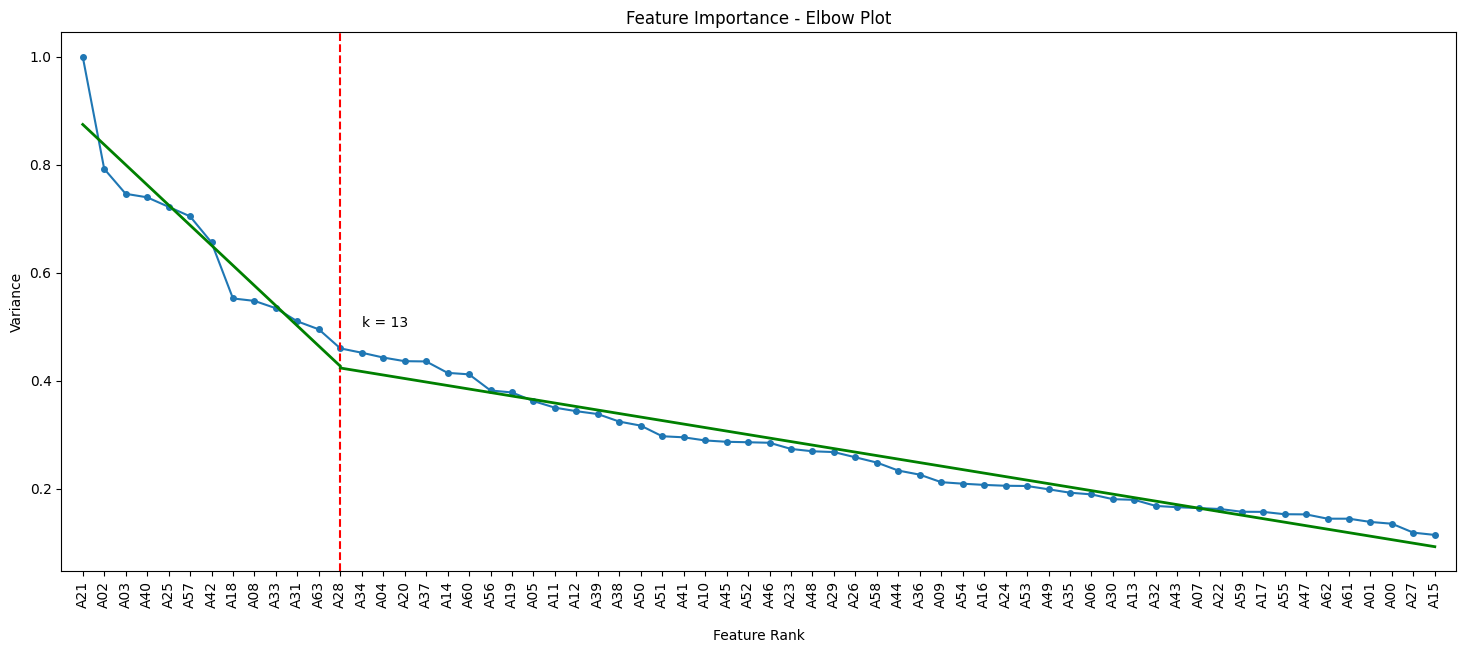

In [ ]:
vals = df_elbow["Overall"].sort_values(ascending=False).values
features = df_sorted["Feature"].tolist()

plt.figure(figsize=(18,7))
plt.plot(range(1, len(vals)+1), vals, marker='o',markersize=4)
plt.xticks(range(1, len(vals)+1), features, rotation=90)

plt.axvline(x=13,linestyle="--",color="red") 

plt.text(14, vals[0]*0.5, "k = 13", rotation=0)
plt.xlim(0, len(vals)+1)

plt.xlabel("Feature Rank", labelpad=15)
plt.ylabel("Variance")
plt.title("Feature Importance - Elbow Plot")

# adding two regression lines: 1 to 13 and 13 to 64
# this wil help with interpretability
# array range for slope range
x = np.arange(1, len(vals)+1) 
x_1 = x[:13]
y_1 = vals[:13]
coef1 = np.polyfit(x_1, y_1, 1)
line1 = np.poly1d(coef1)
plt.plot(x_1, line1(x_1), color="green", linewidth=2)

x_2 = x[12:]
y_2 = vals[12:]
coef2 = np.polyfit(x_2, y_2, 1)
line2 = np.poly1d(coef2)
plt.plot(x_2, line2(x_2), color="green", linewidth=2)

plt.show()

In [ ]:
# moving on with the TabNet Regression Model for predicting the actual normalized values for each year.
print(f"Number of features in the final model: {len(top_features)}")
print(top_features)

Number of features in the final model: 13
['A21', 'A02', 'A03', 'A40', 'A25', 'A57', 'A42', 'A18', 'A08', 'A33', 'A31', 'A63', 'A28']


#### Bayesian Hyperparameter Tuning for TabNet Regressor

https://www.kaggle.com/code/liamhealy/bayesian-hyperparameter-tuning-in-python

Our objective function is RMSE (minimize RMSE).

8 iterations to be performed (backwards loocv):     
read this as [train] -> [target] 
1. [2017,2018,2019,2020,2021,2022,2023] -> [2024]
3. [2017,2018,2019,2020,2021,2022,2024] -> [2023]       
...     
8. [2018,2019,2020,2021,2022,2023,2024] -> [2017]

In [ ]:
# I am doing a quick check here to veryify all county col orderings are the same
# this is so I can keep an identifier when training and testing data, if it is ever needed for debugging. 
# counties_is_same_test = []
# for df in dfs:
# 	counties_is_same_test.append(df["County"])

# reference_series = counties_is_same_test[0]
# all_same = True

# for s in counties_is_same_test[1:]:
# 	if not reference_series.equals(s):
# 		all_same = False
# 		break

# print(all_same)
# county_names = df_2017["County"].copy()

# i removed this from loop 
# i want to actaully keep a clean features matrix
# 	it is very important that this remains constant (on the left)
# 	i never shift rows around, so this should work here
# 	df.insert(0, "County", county_names)

In [ ]:
warnings.filterwarnings('ignore')
# Set Optuna logging level to WARNING (suppresses INFO messages)
optuna.logging.set_verbosity(optuna.logging.WARNING)
logging.getLogger('pytorch_tabnet').setLevel(logging.ERROR)

In [ ]:
def create_objective(X_train, X_test, y_train, y_test):
	def objective(trial):
		params = {
			'n_d': trial.suggest_int('n_d', 8, 64),
			'n_a': trial.suggest_int('n_a', 8, 64),
			'n_steps': trial.suggest_int('n_steps', 3, 10),
			'gamma': trial.suggest_float('gamma', 1.0, 2.0),
			'n_independent': trial.suggest_int('n_independent', 1, 5),
			'n_shared': trial.suggest_int('n_shared', 1, 5),
			'lambda_sparse': trial.suggest_float('lambda_sparse', 1e-6, 1e-3, log=True),
			'momentum': trial.suggest_float('momentum', 0.01, 0.4),
			'clip_value': trial.suggest_float('clip_value', 0.5, 2.0),
			'optimizer_params': {'lr': trial.suggest_float('lr', 1e-4, 1e-1, log=True)},
			'scheduler_params': {
				'step_size': trial.suggest_int('step_size', 10, 50),
				'gamma': trial.suggest_float('scheduler_gamma', 0.5, 0.99)
			},
			'scheduler_fn': torch.optim.lr_scheduler.StepLR,
			'mask_type': 'entmax'
		}

		model = TabNetRegressor(
			n_d=params['n_d'],
			n_a=params['n_a'],
			n_steps=params['n_steps'],
			gamma=params['gamma'],
			n_independent=params['n_independent'],
			n_shared=params['n_shared'],
			lambda_sparse=params['lambda_sparse'],
			momentum=params['momentum'],
			clip_value=params['clip_value'],
			optimizer_fn=torch.optim.Adam,
			optimizer_params=params['optimizer_params'],
			scheduler_params=params['scheduler_params'],
			scheduler_fn=torch.optim.lr_scheduler.StepLR,
			mask_type=params['mask_type'],
			seed=25,
			verbose=0
		)

		# training and testing data is always diff for each iteration
		# there will be 8 iterations total. 
		model.fit(
			X_train = X_train,
			y_train = y_train,
			eval_set = [(X_test, y_test)],
			eval_metric=["rmse"],
			max_epochs = 100,
			patience = 20,
			batch_size = 256,
			virtual_batch_size = 128
		)

		y_pred = model.predict(X_test)
		rmse = np.sqrt(root_mean_squared_error(y_test, y_pred))

		return rmse
	return objective

In [ ]:
def optimization_current_dataset(X_train, X_test, 
																 y_train, y_test, 
																 n_trials=50, 
																 study_name="tabnet_study"):
	'''
	This will be used for when I change my train/test data each iteration.
	I will append the dict result to the ``results`` list in the next cell.  
	'''
	# storing the current iteration reults.

	objective = create_objective(X_train, X_test, y_train, y_test)

	study = optuna.create_study(
		direction='minimize',
		# BO algorithm -> Tree-structured Parzen Estimator
		sampler=TPESampler(seed=25),
		study_name=study_name
  )

	# this is where the optimization takes place.
	study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

	best_params = study.best_params

	final_model = TabNetRegressor(
		n_d=best_params['n_d'],
		n_a=best_params['n_a'],
		n_steps=best_params['n_steps'],
		gamma=best_params['gamma'],
		n_independent=best_params['n_independent'],
		n_shared=best_params['n_shared'],
		lambda_sparse=best_params['lambda_sparse'],
		momentum=best_params['momentum'],
		clip_value=best_params['clip_value'],
		optimizer_params={'lr': best_params['lr']},
		scheduler_params={
				'step_size': best_params['step_size'],
				'gamma': best_params['scheduler_gamma']
		},
		scheduler_fn=torch.optim.lr_scheduler.StepLR,
		mask_type='entmax',
		seed=25,
		verbose=0
	)
    
	final_model.fit(
		X_train=X_train,
		y_train=y_train,
		eval_set=[(X_test, y_test)],
		eval_metric=['rmse'],
		max_epochs=200,
		patience=30,
		batch_size=256,
		virtual_batch_size=128
	)

	dict = {
		'best_params': best_params,
    'best_rmse': study.best_value,
		'model': final_model,
		'study': study
	}
	
	return dict

In [ ]:
# years = np.arange(2017, 2025)

# for test_idx in range(len(dfs) - 1, -1, -1):
# 	test_year = years[test_idx]
# 	train_years = np.delete(years, test_idx)
# 	print(f"testing: {test_year}")
# 	print(f"training: {train_years}")

In [ ]:
# fixing shape issue
# keep consistent target col across dfs
clean_dfs = []

idx = 0
year = 2017
for df in dfs:
	df_year = dfs[idx]

	# -- SET TARGET COLUMN --
	df_year["target"] = df_year[f"Cases_{year}_normalized"]
	df_year = df_year.drop(columns=[f"Cases_{year}_normalized"])

	clean_dfs.append(df_year)

	idx += 1
	year += 1

In [ ]:
clean_dfs[0]

,County,GEOID,A00,A01,A02,A03,A04,A05,A06,A07,...,A57,A58,A59,A60,A61,A62,A63,Cases_2017,2017_population,target
0,Adams,17001.0,-0.107950,-0.037627,0.036348,-0.096245,0.034700,-0.108684,-0.016728,0.094458,...,0.127413,0.021065,-0.041845,-0.121470,-0.088657,-0.168412,0.027029,1.0,66057,1.513844
1,Alexander,17003.0,-0.094824,-0.056673,-0.040527,-0.063669,-0.016219,-0.048929,0.072583,0.073044,...,0.094908,0.069535,-0.060057,-0.077254,-0.143979,-0.098709,0.065627,0.0,6278,0.000000
2,Bond,17005.0,-0.119659,-0.035458,0.015939,-0.073642,0.008038,-0.100312,0.038363,0.071558,...,0.136704,0.013758,-0.091121,-0.110945,-0.098579,-0.125373,0.048798,0.0,16648,0.000000
3,Boone,17007.0,-0.051854,-0.020323,0.071813,-0.172447,0.046811,-0.092647,-0.024340,0.066154,...,0.077935,0.015019,-0.125815,-0.119691,-0.115291,-0.152706,0.032385,1.0,53513,1.868705
4,Brown,17009.0,-0.112111,-0.012204,0.021089,-0.065725,0.043158,-0.120458,-0.007383,0.122192,...,0.122336,0.021527,-0.024922,-0.125496,-0.108772,-0.168290,0.022709,0.0,6609,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,Whiteside,17195.0,-0.072713,-0.077594,0.042785,-0.143906,0.025295,-0.136173,-0.032140,0.108618,...,0.101162,-0.019818,-0.128645,-0.121391,-0.090593,-0.143985,0.063077,0.0,55955,0.000000
98,Will,17197.0,-0.064487,-0.088591,0.062551,-0.139896,0.039499,-0.078033,-0.042707,0.016685,...,0.112932,0.031993,-0.077277,-0.086781,-0.114635,-0.147613,0.005001,1.0,690479,0.144827
99,Williamson,17199.0,-0.140243,-0.058865,-0.017413,0.004954,0.009146,-0.081140,0.018894,0.072165,...,0.150030,0.043505,-0.056262,-0.094795,-0.137470,-0.098129,0.028475,0.0,67049,0.000000
100,Winnebago,17201.0,-0.048765,-0.079403,0.069957,-0.120873,0.062931,-0.106263,-0.041099,0.073488,...,0.103075,0.002925,-0.053409,-0.101476,-0.114592,-0.154284,0.012362,3.0,284681,1.053811


In [ ]:
results = []
# dfs_testing = [df_2017, df_2018, df_2019]

years = np.arange(2017, 2025)

# will run from 0 -- 2017 to 7 -- 2024 (0 indexed starts at 2017)
# reversing the index so iteration 1 starts with 
for test_idx in range(len(clean_dfs) - 1, -1, -1):
	# this is storing the top 13 parameters from the feature selection section
	top_features_copy = top_features.copy()

	test_df = clean_dfs[test_idx]

	train_dfs_list = [clean_dfs[i] for i in range(len(clean_dfs)) if i != test_idx]
	train_dfs = pd.concat(train_dfs_list, ignore_index=True)

	test_year = years[test_idx]
	train_years = [years[i] for i in range(len(clean_dfs)) if i != test_idx]

	X_train = train_dfs[top_features_copy].values
	y_train = train_dfs["target"].values.reshape(-1, 1)

	X_test = test_df[top_features_copy].values
	y_test = test_df["target"].values.reshape(-1, 1)

	# =========== above testing is done ===========

	iter_results_dict = optimization_current_dataset(X_train, X_test, y_train, y_test, study_name=f"tabnet_study_target_{test_year}")
	iter_results_dict["training"] = train_years
	iter_results_dict["testing"] = test_year 

	results.append(iter_results_dict)

  0%|          | 0/50 [00:00<?, ?it/s]


Early stopping occurred at epoch 29 with best_epoch = 9 and best_val_0_rmse = 0.38949

Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_0_rmse = 0.37813

Early stopping occurred at epoch 27 with best_epoch = 7 and best_val_0_rmse = 0.38335

Early stopping occurred at epoch 41 with best_epoch = 21 and best_val_0_rmse = 0.36765

Early stopping occurred at epoch 21 with best_epoch = 1 and best_val_0_rmse = 0.38836

Early stopping occurred at epoch 28 with best_epoch = 8 and best_val_0_rmse = 0.37914

Early stopping occurred at epoch 40 with best_epoch = 20 and best_val_0_rmse = 0.38256

Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_0_rmse = 0.38132

Early stopping occurred at epoch 31 with best_epoch = 11 and best_val_0_rmse = 0.38239

Early stopping occurred at epoch 23 with best_epoch = 3 and best_val_0_rmse = 0.45641

Early stopping occurred at epoch 47 with best_epoch = 27 and best_val_0_rmse = 0.38245

Early stopping occurred at epoch 47 wi

  0%|          | 0/50 [00:00<?, ?it/s]

Stop training because you reached max_epochs = 100 with best_epoch = 90 and best_val_0_rmse = 1.31486

Early stopping occurred at epoch 24 with best_epoch = 4 and best_val_0_rmse = 1.3154

Early stopping occurred at epoch 46 with best_epoch = 26 and best_val_0_rmse = 1.31987

Early stopping occurred at epoch 34 with best_epoch = 14 and best_val_0_rmse = 1.3126

Early stopping occurred at epoch 25 with best_epoch = 5 and best_val_0_rmse = 1.32031

Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_0_rmse = 1.33084

Early stopping occurred at epoch 28 with best_epoch = 8 and best_val_0_rmse = 1.32288

Early stopping occurred at epoch 29 with best_epoch = 9 and best_val_0_rmse = 1.33061

Early stopping occurred at epoch 43 with best_epoch = 23 and best_val_0_rmse = 1.3468

Early stopping occurred at epoch 68 with best_epoch = 48 and best_val_0_rmse = 1.37211

Early stopping occurred at epoch 33 with best_epoch = 13 and best_val_0_rmse = 1.32057

Early stopping occurred a

  0%|          | 0/50 [00:00<?, ?it/s]


Early stopping occurred at epoch 30 with best_epoch = 10 and best_val_0_rmse = 0.44536

Early stopping occurred at epoch 21 with best_epoch = 1 and best_val_0_rmse = 0.44631

Early stopping occurred at epoch 28 with best_epoch = 8 and best_val_0_rmse = 0.44738

Early stopping occurred at epoch 43 with best_epoch = 23 and best_val_0_rmse = 0.44539

Early stopping occurred at epoch 30 with best_epoch = 10 and best_val_0_rmse = 0.44546

Early stopping occurred at epoch 42 with best_epoch = 22 and best_val_0_rmse = 0.4443

Early stopping occurred at epoch 42 with best_epoch = 22 and best_val_0_rmse = 0.44387

Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_0_rmse = 0.44335

Early stopping occurred at epoch 41 with best_epoch = 21 and best_val_0_rmse = 0.44278

Early stopping occurred at epoch 84 with best_epoch = 64 and best_val_0_rmse = 0.44812

Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_0_rmse = 0.74343

Early stopping occurred at epoch 22 

  0%|          | 0/50 [00:00<?, ?it/s]


Early stopping occurred at epoch 31 with best_epoch = 11 and best_val_0_rmse = 0.36696

Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_0_rmse = 0.37063

Early stopping occurred at epoch 28 with best_epoch = 8 and best_val_0_rmse = 0.36422

Early stopping occurred at epoch 30 with best_epoch = 10 and best_val_0_rmse = 0.36078

Early stopping occurred at epoch 47 with best_epoch = 27 and best_val_0_rmse = 0.3588

Early stopping occurred at epoch 38 with best_epoch = 18 and best_val_0_rmse = 0.35952

Early stopping occurred at epoch 50 with best_epoch = 30 and best_val_0_rmse = 0.35435

Early stopping occurred at epoch 22 with best_epoch = 2 and best_val_0_rmse = 0.36489

Early stopping occurred at epoch 30 with best_epoch = 10 and best_val_0_rmse = 0.36458
Stop training because you reached max_epochs = 100 with best_epoch = 85 and best_val_0_rmse = 0.3665

Early stopping occurred at epoch 32 with best_epoch = 12 and best_val_0_rmse = 0.36342

Early stopping occurre

  0%|          | 0/50 [00:00<?, ?it/s]


Early stopping occurred at epoch 32 with best_epoch = 12 and best_val_0_rmse = 0.29013

Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_0_rmse = 0.32419

Early stopping occurred at epoch 28 with best_epoch = 8 and best_val_0_rmse = 0.29944

Early stopping occurred at epoch 31 with best_epoch = 11 and best_val_0_rmse = 0.29284

Early stopping occurred at epoch 21 with best_epoch = 1 and best_val_0_rmse = 0.2955

Early stopping occurred at epoch 38 with best_epoch = 18 and best_val_0_rmse = 0.28644

Early stopping occurred at epoch 32 with best_epoch = 12 and best_val_0_rmse = 0.29179

Early stopping occurred at epoch 32 with best_epoch = 12 and best_val_0_rmse = 0.28859

Early stopping occurred at epoch 28 with best_epoch = 8 and best_val_0_rmse = 0.29147
Stop training because you reached max_epochs = 100 with best_epoch = 90 and best_val_0_rmse = 0.28709

Early stopping occurred at epoch 43 with best_epoch = 23 and best_val_0_rmse = 0.31477

Early stopping occurre

  0%|          | 0/50 [00:00<?, ?it/s]


Early stopping occurred at epoch 34 with best_epoch = 14 and best_val_0_rmse = 2.12021

Early stopping occurred at epoch 23 with best_epoch = 3 and best_val_0_rmse = 2.12305

Early stopping occurred at epoch 37 with best_epoch = 17 and best_val_0_rmse = 2.12168

Early stopping occurred at epoch 58 with best_epoch = 38 and best_val_0_rmse = 2.11541

Early stopping occurred at epoch 41 with best_epoch = 21 and best_val_0_rmse = 2.12178

Early stopping occurred at epoch 21 with best_epoch = 1 and best_val_0_rmse = 2.12319

Early stopping occurred at epoch 58 with best_epoch = 38 and best_val_0_rmse = 2.11878

Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_rmse = 2.11908

Early stopping occurred at epoch 39 with best_epoch = 19 and best_val_0_rmse = 2.12095

Early stopping occurred at epoch 78 with best_epoch = 58 and best_val_0_rmse = 2.13446

Early stopping occurred at epoch 71 with best_epoch = 51 and best_val_0_rmse = 2.11074

Early stopping occurred at epoch 

  0%|          | 0/50 [00:00<?, ?it/s]


Early stopping occurred at epoch 38 with best_epoch = 18 and best_val_0_rmse = 2.078

Early stopping occurred at epoch 26 with best_epoch = 6 and best_val_0_rmse = 2.06789

Early stopping occurred at epoch 34 with best_epoch = 14 and best_val_0_rmse = 2.10314

Early stopping occurred at epoch 36 with best_epoch = 16 and best_val_0_rmse = 2.07345

Early stopping occurred at epoch 45 with best_epoch = 25 and best_val_0_rmse = 2.10153

Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_0_rmse = 2.09426

Early stopping occurred at epoch 36 with best_epoch = 16 and best_val_0_rmse = 2.08624

Early stopping occurred at epoch 37 with best_epoch = 17 and best_val_0_rmse = 2.13423

Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_0_rmse = 2.15831

Early stopping occurred at epoch 67 with best_epoch = 47 and best_val_0_rmse = 2.18021

Early stopping occurred at epoch 26 with best_epoch = 6 and best_val_0_rmse = 2.06962

Early stopping occurred at epoch 26 w

  0%|          | 0/50 [00:00<?, ?it/s]


Early stopping occurred at epoch 48 with best_epoch = 28 and best_val_0_rmse = 1.20749

Early stopping occurred at epoch 24 with best_epoch = 4 and best_val_0_rmse = 1.20805

Early stopping occurred at epoch 36 with best_epoch = 16 and best_val_0_rmse = 1.20718

Early stopping occurred at epoch 25 with best_epoch = 5 and best_val_0_rmse = 1.19902

Early stopping occurred at epoch 66 with best_epoch = 46 and best_val_0_rmse = 1.2026

Early stopping occurred at epoch 22 with best_epoch = 2 and best_val_0_rmse = 1.20649

Early stopping occurred at epoch 23 with best_epoch = 3 and best_val_0_rmse = 1.20366

Early stopping occurred at epoch 26 with best_epoch = 6 and best_val_0_rmse = 1.21083

Early stopping occurred at epoch 48 with best_epoch = 28 and best_val_0_rmse = 1.2093

Early stopping occurred at epoch 88 with best_epoch = 68 and best_val_0_rmse = 1.24362

Early stopping occurred at epoch 54 with best_epoch = 34 and best_val_0_rmse = 1.21103

Early stopping occurred at epoch 27 wi

In [ ]:
print("X_train:", X_train.shape, "y_train:", y_train.shape)


X_train: (714, 13) y_train: (714, 1)


In [ ]:
# save models and everything as pickle file 
with open('tabnet_results_2.pkl', 'wb') as f:
	pickle.dump(results, f)

In [ ]:
# to load results later
with open('tabnet_results_2.pkl', 'rb') as f:
	results = pickle.load(f)

In [ ]:
results

[{'best_params': {'n_d': 39,
   'n_a': 50,
   'n_steps': 9,
   'gamma': 1.823694451925049,
   'n_independent': 1,
   'n_shared': 4,
   'lambda_sparse': 8.467842212767758e-06,
   'momentum': 0.21445894919178746,
   'clip_value': 1.9371385063012128,
   'lr': 0.04462753175143013,
   'step_size': 22,
   'scheduler_gamma': 0.751064234346223},
  'best_rmse': 0.6063416765454746,
  'model': TabNetRegressor(n_d=39, n_a=50, n_steps=9, gamma=1.823694451925049, cat_idxs=[], cat_dims=[], cat_emb_dim=[], n_independent=1, n_shared=4, epsilon=1e-15, momentum=0.21445894919178746, lambda_sparse=8.467842212767758e-06, seed=25, clip_value=1.9371385063012128, verbose=0, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.04462753175143013}, scheduler_fn=<class 'torch.optim.lr_scheduler.StepLR'>, scheduler_params={'step_size': 22, 'gamma': 0.751064234346223}, mask_type='entmax', input_dim=13, output_dim=1, device_name='auto', n_shared_decoder=1, n_indep_decoder=1, grouped_features=[]),
 

#### Best Model:

In [ ]:
# to load results later
with open('tabnet_results.pkl', 'rb') as f:
	results = pickle.load(f)

In [ ]:
for i, n in enumerate(results):
	print(f"index: {i}")
	print(f"best rmse: {n["best_rmse"]}")
	print("")

index: 0
best rmse: 0.6049766591392546

index: 1
best rmse: 1.1453544915959009

index: 2
best rmse: 0.6601326606015698

index: 3
best rmse: 0.5920378236461794

index: 4
best rmse: 0.5333348740209466

index: 5
best rmse: 1.4474533237603373

index: 6
best rmse: 1.436408149697572

index: 7
best rmse: 1.0953957805542316



In [ ]:
best_model = results[4]
best_model

{'best_params': {'n_d': 39,
  'n_a': 50,
  'n_steps': 9,
  'gamma': 1.823694451925049,
  'n_independent': 1,
  'n_shared': 4,
  'lambda_sparse': 8.467842212767758e-06,
  'momentum': 0.21445894919178746,
  'clip_value': 1.9371385063012128,
  'lr': 0.04462753175143013,
  'step_size': 22,
  'scheduler_gamma': 0.751064234346223},
 'best_rmse': 0.5333348740209466,
 'model': TabNetRegressor(n_d=39, n_a=50, n_steps=9, gamma=1.823694451925049, cat_idxs=[], cat_dims=[], cat_emb_dim=[], n_independent=1, n_shared=4, epsilon=1e-15, momentum=0.21445894919178746, lambda_sparse=8.467842212767758e-06, seed=25, clip_value=1.9371385063012128, verbose=0, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.04462753175143013}, scheduler_fn=<class 'torch.optim.lr_scheduler.StepLR'>, scheduler_params={'step_size': 22, 'gamma': 0.751064234346223}, mask_type='entmax', input_dim=13, output_dim=1, device_name='auto', n_shared_decoder=1, n_indep_decoder=1, grouped_features=[]),
 'study': <optu

In [ ]:
best_model["model"]

,n_d,39
,n_a,50
,n_steps,9
,gamma,1.823694451925049
,cat_idxs,[]
,cat_dims,[]
,cat_emb_dim,[]
,n_independent,1
,n_shared,4
,epsilon,1e-15
,momentum,0.21445894919178746


Now, with the best model, I can calculate other things like:
* RMSE (already calculated but will do it again)
* MAE	(lower mean absolute error indicates better model fit)
* R^2 (how much variance is explained by the model)
* Adjusted R^2 for model parsimony (how simple the model is)

In [ ]:
model = best_model["model"]

In [ ]:
print(f"best model training years: { [int(val) for val in best_model["training"]] }")
print(f"best model test year: {best_model["testing"]}")

best model training years: [2017, 2018, 2019, 2021, 2022, 2023, 2024]
best model test year: 2020


In [ ]:
len(clean_dfs)

8

In [ ]:
years = np.arange(2017, 2025)
i = np.where(years == best_model["testing"])[0][0]
test_df = clean_dfs[i]
test_df
i

np.int64(3)

In [ ]:
top_features_copy = top_features.copy()

X_test = test_df[top_features_copy].values
y_test = test_df["target"].values.reshape(-1, 1)

y_pred = model.predict(X_test).reshape(-1)
y_true = y_test.reshape(-1)

In [ ]:
rmse = root_mean_squared_error(y_true, y_pred)
mae  = mean_absolute_error(y_true, y_pred)
r2   = r2_score(y_true, y_pred)

In [ ]:
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R^2: {r2}")

RMSE: 0.2928370472947467
MAE: 0.09309516184398127
R^2: -0.027108463889777168


In [ ]:
print(y_true.mean())
print(y_true.std())
print(y_true.var())

0.05775826365272449
0.288946784033991
0.08349024400358582


this below shows why 

In [ ]:
print("y_true variance:", np.var(y_true))
print("RMSE^2:", rmse**2)

y_true variance: 0.08349024400358582
RMSE^2: 0.0857535362683057


In [ ]:
from scipy.stats import pearsonr

corr, p_value = pearsonr(y_true, y_pred)
print("Pearson r:", corr)
print("p-value:", p_value)

Pearson r: 0.04097130042767361
p-value: 0.6826410622370729


#### Final model after going back and using `entmax`:

In [ ]:
# to load results later
with open('tabnet_results_2.pkl', 'rb') as f:
	results = pickle.load(f)

In [ ]:
results

[{'best_params': {'n_d': 39,
   'n_a': 50,
   'n_steps': 9,
   'gamma': 1.823694451925049,
   'n_independent': 1,
   'n_shared': 4,
   'lambda_sparse': 8.467842212767758e-06,
   'momentum': 0.21445894919178746,
   'clip_value': 1.9371385063012128,
   'lr': 0.04462753175143013,
   'step_size': 22,
   'scheduler_gamma': 0.751064234346223},
  'best_rmse': 0.6063416765454746,
  'model': TabNetRegressor(n_d=39, n_a=50, n_steps=9, gamma=1.823694451925049, cat_idxs=[], cat_dims=[], cat_emb_dim=[], n_independent=1, n_shared=4, epsilon=1e-15, momentum=0.21445894919178746, lambda_sparse=8.467842212767758e-06, seed=25, clip_value=1.9371385063012128, verbose=0, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.04462753175143013}, scheduler_fn=<class 'torch.optim.lr_scheduler.StepLR'>, scheduler_params={'step_size': 22, 'gamma': 0.751064234346223}, mask_type='entmax', input_dim=13, output_dim=1, device_name='auto', n_shared_decoder=1, n_indep_decoder=1, grouped_features=[]),
 

In [ ]:
for i, n in enumerate(results):
	print(f"index: {i}")
	print(f"best rmse: {n["best_rmse"]}")
	print("")

index: 0
best rmse: 0.6063416765454746

index: 1
best rmse: 1.1430516551465981

index: 2
best rmse: 0.6635722912061695

index: 3
best rmse: 0.590224430938136

index: 4
best rmse: 0.5323326989106633

index: 5
best rmse: 1.4502280947159227

index: 6
best rmse: 1.4379465535433775

index: 7
best rmse: 1.0933626548502429



In [ ]:
best_model = results[4]
best_model

{'best_params': {'n_d': 22,
  'n_a': 64,
  'n_steps': 8,
  'gamma': 1.3882536828069219,
  'n_independent': 5,
  'n_shared': 2,
  'lambda_sparse': 3.114747793904801e-05,
  'momentum': 0.19235242790658713,
  'clip_value': 0.8661450437959525,
  'lr': 0.0007401687679520606,
  'step_size': 37,
  'scheduler_gamma': 0.5616422998248747},
 'best_rmse': 0.5323326989106633,
 'model': TabNetRegressor(n_d=22, n_a=64, n_steps=8, gamma=1.3882536828069219, cat_idxs=[], cat_dims=[], cat_emb_dim=[], n_independent=5, n_shared=2, epsilon=1e-15, momentum=0.19235242790658713, lambda_sparse=3.114747793904801e-05, seed=25, clip_value=0.8661450437959525, verbose=0, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.0007401687679520606}, scheduler_fn=<class 'torch.optim.lr_scheduler.StepLR'>, scheduler_params={'step_size': 37, 'gamma': 0.5616422998248747}, mask_type='entmax', input_dim=13, output_dim=1, device_name='auto', n_shared_decoder=1, n_indep_decoder=1, grouped_features=[]),
 'study

In [ ]:
best_model["model"]

,n_d,22
,n_a,64
,n_steps,8
,gamma,1.3882536828069219
,cat_idxs,[]
,cat_dims,[]
,cat_emb_dim,[]
,n_independent,5
,n_shared,2
,epsilon,1e-15
,momentum,0.19235242790658713


Now, with the best model, I can calculate other things like:
* RMSE (already calculated but will do it again)
* MAE	(lower mean absolute error indicates better model fit)
* R^2 (how much variance is explained by the model)
* Adjusted R^2 for model parsimony (how simple the model is)

In [ ]:
model = best_model["model"]

In [ ]:
print(f"best model training years: { [int(val) for val in best_model["training"]] }")
print(f"best model test year: {best_model["testing"]}")

best model training years: [2017, 2018, 2019, 2021, 2022, 2023, 2024]
best model test year: 2020


In [ ]:
years = np.arange(2017, 2025)
i = np.where(years == best_model["testing"])[0][0]
test_df = clean_dfs[i]
test_df
i

np.int64(3)

In [ ]:
top_features_copy = top_features.copy()

X_test = test_df[top_features_copy].values
y_test = test_df["target"].values.reshape(-1, 1)

y_pred = model.predict(X_test).reshape(-1)
y_true = y_test.reshape(-1)

In [ ]:
rmse = root_mean_squared_error(y_true, y_pred)
mae  = mean_absolute_error(y_true, y_pred)
r2   = r2_score(y_true, y_pred)

In [ ]:
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R^2: {r2}")

RMSE: 0.28337810232951083
MAE: 0.1104536846068818
R^2: 0.038173263975300076


In [ ]:
print(y_true.mean())
print(y_true.std())
print(y_true.var())

0.05775826365272449
0.288946784033991
0.08349024400358582


this below shows why 

In [ ]:
print("y_true variance:", np.var(y_true))
print("RMSE^2:", rmse**2)

y_true variance: 0.08349024400358582
RMSE^2: 0.0803031488798747


In [ ]:
from scipy.stats import pearsonr

corr, p_value = pearsonr(y_true, y_pred)
print("Pearson r:", corr)
print("p-value:", p_value)

Pearson r: 0.20187160208015797
p-value: 0.041883644602707354
